# Bayesian Optimisation of starting Gaussian Process hyperparameters

In [1]:
from pathlib import Path
from shutil import copyfile
import pickle

Data manipulation

In [2]:
import numpy as np
import pandas as pd

Plotting / Visualisation

In [3]:
import matplotlib.pyplot as plt

In [4]:
from bokeh.palettes import d3

In [5]:
pallete = d3['Category10'][10]

In [6]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 6)

Gaussian Process Regression

In [7]:
import gpflow
import tensorflow as tf

In [8]:
from tensorflow.python.client import device_lib
from gpflow.ci_utils import ci_niter
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 142253589590111159]

In [9]:
from gpflow.utilities import print_summary

In [10]:
gpflow.config.set_default_summary_fmt("notebook")

In [11]:
from tqdm.contrib.itertools import product

Input scaler:

In [12]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.exceptions import NotFittedError

In [13]:
from helpers import ScalerHelper

## Load previously exported data

In [14]:
dfs_train = []
dfs_test = []

In [15]:
train_exps = ['Exp1', 'Exp3', 'Exp5', 'Exp6']
test_exps = ['Exp2', 'Exp4', 'Exp7']

In [16]:
for exp in train_exps:
    dfs_train.append(pd.read_csv(f"../Data/Good_CARNOT/{exp}_table.csv").rename(columns = {'Power': 'SimulatedHeat'}))
    
for exp in test_exps:
    dfs_test.append(pd.read_csv(f"../Data/Good_CARNOT/{exp}_table.csv").rename(columns = {'Power': 'SimulatedHeat'}))

In [17]:
#t_cols = ['time_h', 'time_m']
t_cols = []
w_cols = ['SolRad', 'OutsideTemp']
u_cols = ['SimulatedHeat']
y_cols = ['SimulatedTemp']

In [18]:
t_lags = 0
w_lags = 1
u_lags = 1
y_lags = 3

In [19]:
dict_cols = {
    't': (t_lags, t_cols),
    'w': (w_lags, w_cols),
    'u': (u_lags, u_cols),
    'y': (y_lags, y_cols)
}

Create the scaler and set up input data scaling:

In [20]:
scaler = MinMaxScaler(feature_range = (-1, 1))

In [21]:
def get_scaled_df(df, dict_cols, scaler):
    
    t_list = dict_cols['t'][1]
    w_list = dict_cols['w'][1]
    u_list = dict_cols['u'][1]
    y_list = dict_cols['y'][1]
    
    df_local = df[t_list + w_list + u_list + y_list]
    df_scaled = df_local.to_numpy()
    
    try:
        df_scaled = scaler.transform(df_scaled)
    except NotFittedError:
        df_scaled = scaler.fit_transform(df_scaled)
        
    df_scaled = pd.DataFrame(df_scaled, index = df_local.index, columns = df_local.columns)
    
    return df_scaled

In [22]:
df_train = pd.concat(dfs_train)
df_train = df_train[t_cols + w_cols + u_cols + y_cols]
df_train.head()

,SolRad,OutsideTemp,SimulatedHeat,SimulatedTemp
0,57.936582,22.0,-31500,23.000000
1,54.914443,22.0,-31500,20.585367
2,73.944706,22.0,-31500,20.300922
3,76.206334,22.0,-31500,20.034647
4,65.120057,22.0,-31500,19.786064


Fit the scaler and scale the data:

In [23]:
df_train_sc = get_scaled_df(df_train, dict_cols, scaler)
#pickle.dump(scaler, open(Path("scaler.pkl"), 'wb'))

In [24]:
scaler_helper = ScalerHelper(scaler)

Scale the data for each experiment individually. Used for validation graphs and errors computation:

In [25]:
dfs_train_sc = []
dfs_test_sc = []
for df in dfs_train:
    df_sc = get_scaled_df(df, dict_cols, scaler)
    dfs_train_sc.append(df_sc)
    
for df in dfs_test:
    df_sc = get_scaled_df(df, dict_cols, scaler)
    dfs_test_sc.append(df_sc)

Set up the function which generated the GPR input matrix from the experimental data (including all autoregressive inputs, etc.):

In [26]:
def data_to_gpr(df, dict_cols):
    
    t_list = dict_cols['t'][1]
    w_list = dict_cols['w'][1]
    u_list = dict_cols['u'][1]
    y_list = dict_cols['y'][1]
    
    df_gpr = df[t_list + w_list + u_list + y_list].copy()
    
    for lags, names in dict_cols.values():
        for name in names:
            col_idx = df_gpr.columns.get_loc(name)
            for lag in range(1, lags + 1):
                df_gpr.insert(col_idx + lag, f"{name}_{lag}", df_gpr.loc[:, name].shift(lag))

    df_gpr.dropna(inplace = True)
    
    return df_gpr

In [27]:
dfs_gpr_train = []
for df_sc in dfs_train_sc:
    dfs_gpr_train.append(data_to_gpr(df_sc, dict_cols))
df_gpr_train = pd.concat(dfs_gpr_train)
df_gpr_train.head()

,SolRad,SolRad_1,OutsideTemp,OutsideTemp_1,SimulatedHeat,SimulatedHeat_1,SimulatedTemp,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
3,-0.855164,-0.859463,0.058824,0.058824,-1.0,-1.0,-0.295224,-0.270561,-0.244215,-0.020567
4,-0.876235,-0.855164,0.058824,0.058824,-1.0,-1.0,-0.318248,-0.295224,-0.270561,-0.244215
5,-0.911207,-0.876235,0.058824,0.058824,-1.0,-1.0,-0.340062,-0.318248,-0.295224,-0.270561
6,-0.933425,-0.911207,0.058824,0.058824,1.0,-1.0,-0.361066,-0.340062,-0.318248,-0.295224
7,-0.952322,-0.933425,0.058824,0.058824,-1.0,1.0,0.051533,-0.361066,-0.340062,-0.318248


In [28]:
train_dataset_size = 15 * 96
train_dataset_size = -1

In [29]:
df_gpr_train = df_gpr_train.iloc[:train_dataset_size,:]

In [30]:
dfs_gpr_test = []
for df_sc in dfs_test_sc:
    dfs_gpr_test.append(data_to_gpr(df_sc, dict_cols))

In [31]:
df_input_train = df_gpr_train.drop(columns = dict_cols['w'][1] + dict_cols['u'][1] + dict_cols['y'][1])
df_output_train = df_gpr_train[dict_cols['y'][1]]

np_input_train = df_input_train.to_numpy()
np_output_train = df_output_train.to_numpy().reshape(-1, 1)

In [32]:
data_train = (np_input_train, np_output_train)
#pickle.dump(data_train, open(Path("data_train.pkl"), 'wb'))

In [33]:
df_input_train.head()

,SolRad_1,OutsideTemp_1,SimulatedHeat_1,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
3,-0.859463,0.058824,-1.0,-0.270561,-0.244215,-0.020567
4,-0.855164,0.058824,-1.0,-0.295224,-0.270561,-0.244215
5,-0.876235,0.058824,-1.0,-0.318248,-0.295224,-0.270561
6,-0.911207,0.058824,-1.0,-0.340062,-0.318248,-0.295224
7,-0.933425,0.058824,1.0,-0.361066,-0.340062,-0.318248


In [34]:
## Define Kernel

In [35]:
nb_dims = np_input_train.shape[1]
rational_dims = np.arange(0, (dict_cols['t'][0] + 1) * len(dict_cols['t'][1]), 1)
nb_rational_dims = len(rational_dims)
squared_dims = np.arange(nb_rational_dims, nb_dims, 1)
nb_squared_dims = len(squared_dims)

In [36]:
print(f"rational: {nb_rational_dims}")
print(f"squared: {nb_squared_dims}")

rational: 0
squared: 6


In [37]:
squared_l = np.linspace(1, 1, nb_squared_dims)
rational_l = np.linspace(1, 1, nb_rational_dims)

In [38]:
variance = tf.math.reduce_variance(np_input_train)

In [39]:
k0 = gpflow.kernels.SquaredExponential(lengthscales = squared_l, active_dims = squared_dims, variance = variance)
k1 = gpflow.kernels.Constant(variance = variance)
k2 = gpflow.kernels.RationalQuadratic(lengthscales = rational_l, active_dims = rational_dims, variance = variance)
k3 = gpflow.kernels.Periodic(k2)

In [40]:
k = (k0 + k1) * k2
k = k0
print_summary(k)

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,,True,(),float64,0.3732985081118343
SquaredExponential.lengthscales,Parameter,Softplus,,True,"(6,)",float64,"[1., 1., 1...."


## Compile Model

In [41]:
m = gpflow.models.GPR(
    data = data_train, 
    kernel = k, 
    mean_function = None,
    )
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.3732985081118343
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(6,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


## Train Model

In [42]:
opt = gpflow.optimizers.Scipy()

In [43]:
from datetime import datetime

In [44]:
start_time = datetime.now()
opt.minimize(m.training_loss, m.trainable_variables)
print(f"Finished fitting in {datetime.now() - start_time}")
print_summary(m)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Finished fitting in 0:01:40.111253


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.29094154974394787
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(6,)",float64,"[11.58741699, 0.58887124, 7.91572841..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.3118056959789448e-05


## Evaluate performance on training data

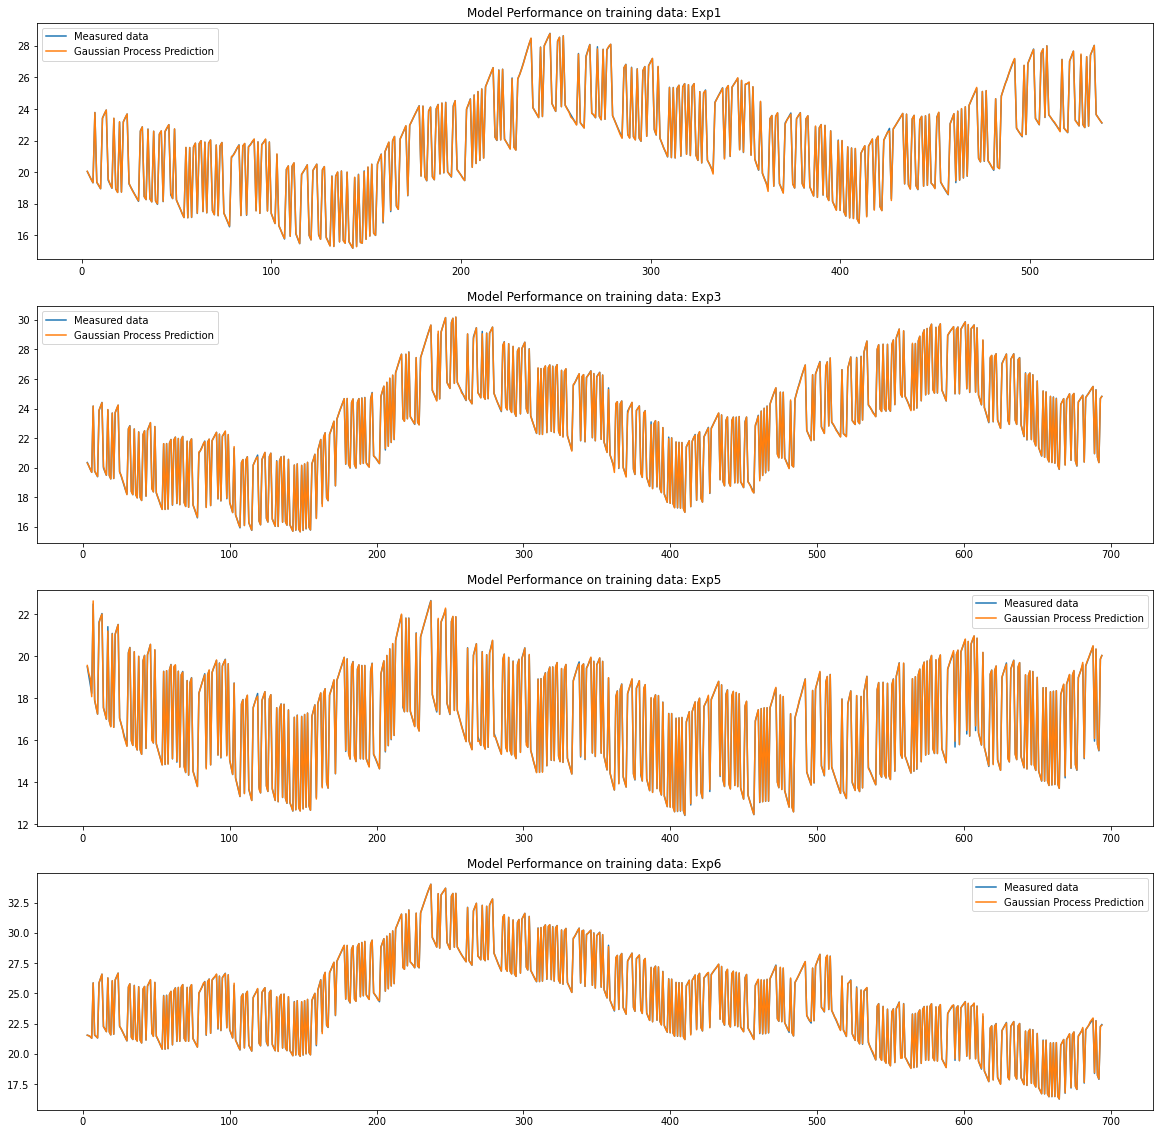

In [45]:
nb_plts = len(dfs_train)

fig, ax = plt.subplots(4, 1, figsize=(20, 20))

for idx, df_iter in enumerate(dfs_gpr_train):
    plt.subplot(4, 1, idx + 1)
    df_input_iter = df_iter.drop(columns = dict_cols['w'][1] + dict_cols['y'][1] + dict_cols['u'][1])
    df_output_iter = df_iter[dict_cols['y'][1]]
    np_input_iter = df_input_iter.to_numpy()
    np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)
    
    mean, var = m.predict_f(np_input_iter)
    
    mean = scaler_helper.inverse_scale_output(mean).reshape((-1, 1))
    #var = scaler_helper.inverse_scale_output(var).reshape((-1, 1))
    scaled_measures = scaler_helper.inverse_scale_output(np_output_iter[:, :])
    
    plt.plot(df_iter.index, scaled_measures, label = 'Measured data')
    plt.plot(df_iter.index, mean, label = 'Gaussian Process Prediction')
    plt.fill_between(
        df_iter.index, 
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        alpha = 0.2
    )
    plt.title(f"Model Performance on training data: {train_exps[idx]}")
    plt.legend()
plt.savefig(f"../Thesis/Plots/GP_{w_lags}{u_lags}{y_lags}_training_performance.pdf", bbox_inches='tight')

## Evaluate performance on test data

In [46]:
def SMSE(measured, predicted):
    N = measured.size
    measured_var = np.var(measured)
    SMSE = np.power(measured - predicted, 2).sum()/(N*measured_var)
    return SMSE

In [47]:
def RMSE(measured, predicted):
    N = measured.size
    RMSE = np.sqrt(np.power(measured - predicted, 2).sum()/N)
    return RMSE

In [48]:
def LPD(measured, predicted_mean, predicted_var):
    N = measured.size
    sum_part = np.log(predicted_var) + np.power(measured - predicted_mean, 2)/predicted_var
    LPD = 1/2*np.log(2*np.pi) + 1/(2*N)*sum_part.sum()
    return LPD

In [49]:
def MSLL(measured, predicted_mean, predicted_var):
    measured_var = np.var(measured)
    measured_mean = np.mean(measured)
    return LPD(measured, predicted_mean, predicted_var) - LPD(measured, measured_mean, measured_var)

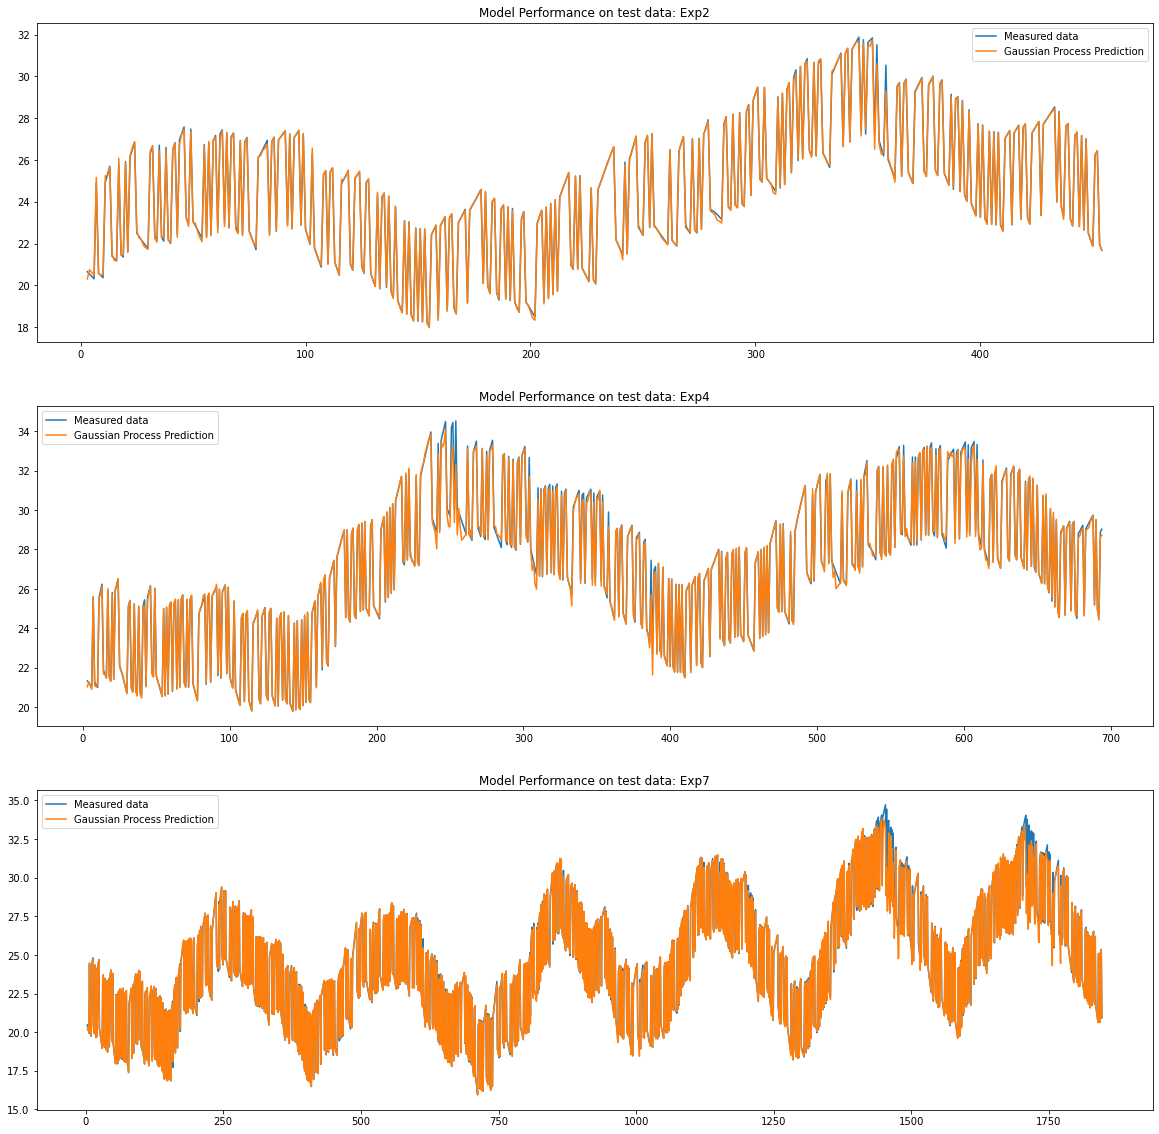

In [50]:
nb_plts = len(dfs_test)

test_smse = 0
test_rmse = 0
test_lpd = 0
test_msll = 0

plt.figure(figsize = (20, 20))

for idx, df_iter in enumerate(dfs_gpr_test):
    plt.subplot(nb_plts, 1, idx + 1)
    df_input_iter = df_iter.drop(columns = dict_cols['w'][1] + dict_cols['y'][1] + dict_cols['u'][1])
    df_output_iter = df_iter[dict_cols['y'][1]]
    np_input_iter = df_input_iter.to_numpy()
    np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)
    
    mean, var = m.predict_f(np_input_iter)
    mean = mean.numpy()
    var = var.numpy()
    
    test_smse += SMSE(np_output_iter, mean)
    test_rmse += RMSE(np_output_iter, mean)
    test_lpd += LPD(np_output_iter, mean, var)
    test_msll += MSLL(np_output_iter, mean, var)
    
    mean = scaler_helper.inverse_scale_output(mean).reshape((-1, 1))
    #var = scaler_helper.inverse_scale_output(var).reshape((-1, 1))
    scaled_measures = scaler_helper.inverse_scale_output(np_output_iter[:, :])
    
    plt.plot(df_iter.index, scaled_measures, label = 'Measured data')
    plt.plot(df_iter.index, mean[:, :], label = 'Gaussian Process Prediction')
    plt.fill_between(
        df_iter.index, 
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        alpha = 0.2
    )
    plt.title(f"Model Performance on test data: {test_exps[idx]}")
    plt.legend()
plt.savefig(f"../Thesis/Plots/GP_{w_lags}{u_lags}{y_lags}_test_performance.pdf", bbox_inches='tight')

In [51]:
print(f"--- Lags ---")
print(f"w_lags: {w_lags}, u_lags: {u_lags}, y_lags: {y_lags}")
print("--- Test errors ---")
print(f"RMSE: {test_rmse}, SMSE: {test_smse}, MSLL: {test_msll}, LPD: {test_lpd}")

--- Lags ---
w_lags: 1, u_lags: 1, y_lags: 3
--- Test errors ---
RMSE: 0.05880460069770413, SMSE: 0.010646871619510608, MSLL: -8.984799522408483, LPD: -8.031441265120948


## Generate a table of errors and lengthscales

In [52]:
#t_cols = ['time_h', 'time_m']
t_cols = []
w_cols = ['SolRad', 'OutsideTemp']
u_cols = ['SimulatedHeat']
y_cols = ['SimulatedTemp']

In [56]:
# Max lags, used to generate columns index
t_lags = 0
w_lags = 5
u_lags = 5
y_lags = 5

In [57]:
dict_cols = {
    't': (t_lags, t_cols),
    'w': (w_lags, w_cols),
    'u': (u_lags, u_cols),
    'y': (y_lags, y_cols)
}

In [54]:
lags_cols = ['w_lags', 'u_lags', 'y_lags']
err_cols = ['rmse', 'smse', 'msll', 'lpd'] + ['variance']
lscales_cols = data_to_gpr(df_sc, dict_cols).drop(columns = dict_cols['w'][1] + dict_cols['y'][1] + dict_cols['u'][1]).columns.to_list()

In [56]:
df_perf_cols = lags_cols + err_cols + lscales_cols

In [57]:
np_perf = np.empty((0, len(df_perf_cols)))

In [58]:
w_range = np.arange(1,6)
u_range = np.arange(1,6)
y_range = np.arange(1,6)

In [ ]:
np_perf = np.empty((0, len(df_perf_cols)))
for w_iter, u_iter, y_iter in product(w_range, u_range, y_range):
    
    # Define dict_cols
    dict_cols = {
        't': (t_lags, t_cols),
        'w': (w_iter, w_cols),
        'u': (u_iter, u_cols),
        'y': (y_iter, y_cols)
    }
    
    # Training data
    dfs_gpr_train = []
    for df_sc in dfs_train_sc:
        dfs_gpr_train.append(data_to_gpr(df_sc, dict_cols))
    df_gpr_train = pd.concat(dfs_gpr_train)
    
    dfs_gpr_test = []
    for df_sc in dfs_test_sc:
        dfs_gpr_test.append(data_to_gpr(df_sc, dict_cols))
        
    df_input_train = df_gpr_train.drop(columns = dict_cols['w'][1] + dict_cols['u'][1] + dict_cols['y'][1])
    df_output_train = df_gpr_train[dict_cols['y'][1]]

    np_input_train = df_input_train.to_numpy()
    np_output_train = df_output_train.to_numpy().reshape(-1, 1)

    data_train = (np_input_train, np_output_train)

    
    # Kernel
    nb_dims = np_input_train.shape[1]
    rational_dims = np.arange(0, (dict_cols['t'][0] + 1) * len(dict_cols['t'][1]), 1)
    nb_rational_dims = len(rational_dims)
    squared_dims = np.arange(nb_rational_dims, nb_dims, 1)
    nb_squared_dims = len(squared_dims)
    
    squared_l = np.linspace(1, 1, nb_squared_dims)
    rational_l = np.linspace(1, 1, nb_rational_dims)
    
    k0 = gpflow.kernels.SquaredExponential(lengthscales = squared_l, active_dims = squared_dims, variance = variance)
    
    k = k0
    
    nb_tries = 0
    train_success = False
    while True:
        try:
            if nb_tries > 2:
                break
            k0 = gpflow.kernels.SquaredExponential(lengthscales = squared_l, active_dims = squared_dims, variance = variance)
            k = k0

            # Model definition and training
            m = gpflow.models.GPR(
            data = data_train, 
            kernel = k, 
            mean_function = None,
            )

            opt = gpflow.optimizers.Scipy()
            opt.minimize(m.training_loss, m.trainable_variables)
            train_success = True
            break
        except:
            nb_tries += 1
        
    if not train_success:
        continue
    
    nb_plts = len(dfs_test)

    test_smse = 0
    test_rmse = 0
    test_lpd = 0
    test_msll = 0

    for idx, df_iter in enumerate(dfs_gpr_test):
        df_input_iter = df_iter.drop(columns = dict_cols['w'][1] + dict_cols['y'][1] + dict_cols['u'][1])
        df_output_iter = df_iter[dict_cols['y'][1]]
        np_input_iter = df_input_iter.to_numpy()
        np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)

        mean, var = m.predict_f(np_input_iter)

        test_smse += SMSE(np_output_iter, mean.numpy())
        test_rmse += RMSE(np_output_iter, mean.numpy())
        test_lpd += LPD(np_output_iter, mean.numpy(), var.numpy())
        test_msll += MSLL(np_output_iter, mean.numpy(), var.numpy())
        
    # Compute the current row in df_perf
    
    iter_lagcols = df_input_train.columns.tolist()
    
    np_perf_iter = np.nan * np.ones((1, len(df_perf_cols)))
    np_perf_iter[0,0] = w_iter
    np_perf_iter[0,1] = u_iter
    np_perf_iter[0,2] = y_iter
    np_perf_iter[0,3] = test_rmse
    np_perf_iter[0,4] = test_smse
    np_perf_iter[0,5] = test_msll
    np_perf_iter[0,6] = test_lpd
    np_perf_iter[0,7] = gpflow.utilities.parameter_dict(m)['.kernel.variance'].numpy()
    
    for iter_lag in iter_lagcols:
        iter_lag_idx = df_input_train.columns.to_list().index(iter_lag)
        perf_lag_idx = df_perf_cols.index(iter_lag)
        np_perf_iter[0,perf_lag_idx] = gpflow.utilities.parameter_dict(m)['.kernel.lengthscales'].numpy()[iter_lag_idx]
        

    np_perf = np.vstack([np_perf, np_perf_iter])
    
    # Save the output for this iteration
    df_perf_iter = pd.DataFrame(np_perf, columns = df_perf_cols).to_csv(f"df_perf_GP_{w_iter}w_{u_iter}u_{y_iter}y.csv")

  0%|          | 0/125 [00:00<?, ?it/s]

## Multistep prediction

In [52]:
test_dataset_idx = 1
df_input = dfs_gpr_test[test_dataset_idx].drop(columns = dict_cols['w'][1] + dict_cols['u'][1] + dict_cols['y'][1])
df_output = dfs_gpr_test[test_dataset_idx][dict_cols['y'][1]]

In [53]:
start_idx = 25
nb_predictions = 25
N_pred = 20

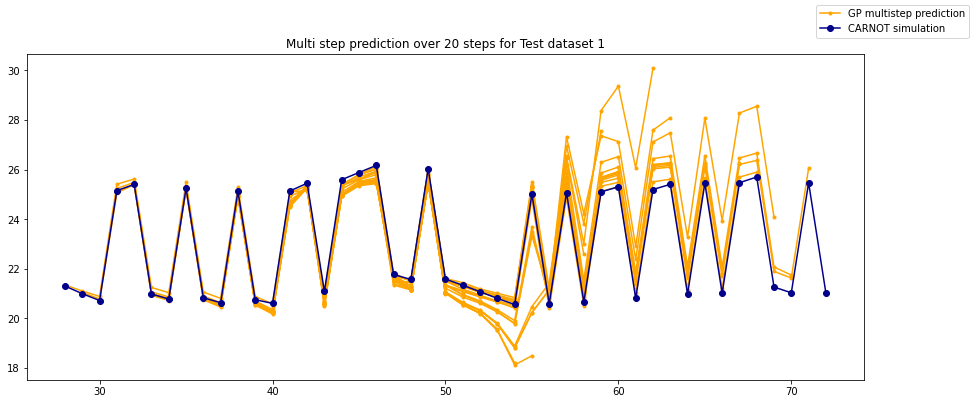

In [55]:
fig, ax = plt.subplots()

y_name = dict_cols['y'][1][0]
for idx in range(start_idx, start_idx + nb_predictions):
    df_iter = df_input.iloc[idx:(idx + N_pred)].copy()
    for idxx in range(N_pred - 1):
        idx_old = df_iter.index[idxx]
        idx_new = df_iter.index[idxx+1]
        mean, var = m.predict_f(df_iter.loc[idx_old, :].to_numpy().reshape(1, -1))
        df_iter.loc[idx_new, f'{y_name}_1'] = mean.numpy().flatten()
        for lag in range(2, dict_cols['y'][0] + 1):
            df_iter.loc[idx_new, f"{y_name}_{lag}"] = df_iter.loc[idx_old, f"{y_name}_{lag-1}"]

    mean_iter, var_iter = m.predict_f(df_iter.to_numpy())
    mean_iter = scaler_helper.inverse_scale_output(mean_iter)
    plt.plot(df_iter.index, mean_iter, '.-', label = 'GP multistep prediction', color = 'orange')   
scaled_index = df_output.iloc[start_idx:start_idx + nb_predictions + N_pred].index
scaled_measurement = scaler_helper.inverse_scale_output(df_output.iloc[start_idx:start_idx + nb_predictions + N_pred])
plt.plot(scaled_index, scaled_measurement, 'o-', label = 'CARNOT simulation', color = 'darkblue')


handles, labels = ax.get_legend_handles_labels()
idx = np.sort(np.unique(np.array(labels), return_index=True)[1])
fig.legend(np.array(handles)[idx], np.array(labels)[idx])

plt.title(f"Multi step prediction over {N_pred} steps for Test dataset {test_dataset_idx}")
plt.savefig(f"../Thesis/Plots/GP_{w_lags}{u_lags}{y_lags}_{train_dataset_size}pts_test_prediction_{N_pred}_steps.png")

In [141]:
m.data[0].shape

TensorShape([2612, 7])